In [2]:
import pandas as pd
import numpy as np
import sys

# Kütüphane kurulumu
!{sys.executable} -m pip install -q scikit-learn

# CSV yolunu ayarla
csv_path = "Police_Transparency_-_Arrests_-_All_Data_(main_table___denormalized).csv"

#Dosya yolu konrtolü 
try:
    # Veriyi yükle
    df = pd.read_csv(csv_path, low_memory=False)
    print("✔ Veri seti başarıyla yüklendi.")
except Exception as e:
    print(f"❌ Veri yükleme hatası: {e}")
    raise SystemExit
    
# Boyut bilgisi
print(f"Veri boyutu: {df.shape}")
display(df.head())


✔ Veri seti başarıyla yüklendi.
Veri boyutu: (47444, 40)


,X,Y,rin,primary_key,arrest_type,arrest_translation,arrest_dt,arrest_time,arrest_hour_of_day,location,...,severity_code,severity_trans,ChargeClassTranslation,ChargeGrouping,arrestee_sex,arrestee_race,arrestee_ethnicity,arrestee_genderTranslation,arrestee_RaceAndEthnicity,ESRI_OID
0,693985,882475,110528,TE20226631,O,On-View: Arrested when first observed/investi...,2022/09/24 21:17:00+00,2117,21,2XX E 5TH ST,...,NaN,Unknown,Arizona Revised Statutes,Miscellaneous,M,B,N,Male,Black or African American,3715748
1,710663,880237,110739,TE20226842,T,Taken Into Custody: Arrest on warrant or PC f...,2022/10/04 17:30:00+00,1730,17,9XX S ACORN AVE,...,F,Felony,Arizona Revised Statutes,Drug charges,M,W,N,Male,White,3715749
2,704259,878441,110587,TE20226690,T,Taken Into Custody: Arrest on warrant or PC f...,2022/09/27 21:52:00+00,2152,21,1XXX E APACHE BLVD,...,M,Misdemeanor,Arizona Revised Statutes,Assault & related charges,M,W,H,Male,Hispanic or Latino,3715750
3,693160,868321,110521,TE20226624,O,On-View: Arrested when first observed/investi...,2022/09/24 21:00:00+00,2100,21,4XXX S MILL AVE,...,F,Felony,Arizona Revised Statutes,Miscellaneous,M,B,N,Male,Black or African American,3715751
4,708569,883842,110789,TE20226892,T,Taken Into Custody: Arrest on warrant or PC f...,2022/10/07 03:54:00+00,354,3,2XXX W RIO SALADO PKWY,...,M,Misdemeanor,Arizona Revised Statutes,Escape & related charges,M,W,H,Male,Hispanic or Latino,3715752


In [3]:
print("\n--- TEKİLLEŞTİRME ---")

initial_rows = df.shape[0]

# Yinelenen satırları sil
df.drop_duplicates(inplace=True)

# Silinen satır sayısını hesapla
removed = initial_rows - df.shape[0]

print(f"✔ {removed} adet yinelenen satır silindi.")
print(f"Yeni veri boyutu: {df.shape}")



--- TEKİLLEŞTİRME ---
✔ 0 adet yinelenen satır silindi.
Yeni veri boyutu: (47444, 40)


In [4]:
# Silinecek sütunların listesi
columns_to_drop = [
    'X','Y','rin','primary_key','charge_rin','pin','ESRI_OID',
    'x_coordinate','y_coordinate',
    'arrest_officer',
    'ofc_age_range','ofc_genderTranslation','ofc_RaceAndEthnicity',
    'statute','class','severity_code'
]

# HATA ÖNLEYİCİ: Veri setinde gerçekten var olan sütunları seç
existing_cols = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_cols, inplace=True)

print(f"✔ {len(existing_cols)} sütun kaldırıldı.")
print("Kaldırılanlar:", existing_cols)


✔ 16 sütun kaldırıldı.
Kaldırılanlar: ['X', 'Y', 'rin', 'primary_key', 'charge_rin', 'pin', 'ESRI_OID', 'x_coordinate', 'y_coordinate', 'arrest_officer', 'ofc_age_range', 'ofc_genderTranslation', 'ofc_RaceAndEthnicity', 'statute', 'class', 'severity_code']


In [5]:
print("\n--- Eksik Veri Analizi ---")

# Her sütundaki eksik veri oranını (%) hesapla ve büyükten küçüğe sırala
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

# En çok eksik veriye sahip ilk 20 sütunu göster
display(missing.head(20))
print("\nVeri boyutu:", df.shape)



--- Eksik Veri Analizi ---


area_name                     5.667735
zipcode                       5.225107
arrest_translation            1.199309
arrest_type                   1.199309
ChargeGrouping                0.265576
arrestee_ethnicity            0.073771
arrestee_age_range            0.067448
arrestee_RaceAndEthnicity     0.040047
arrestee_genderTranslation    0.040047
arrestee_race                 0.040047
arrestee_sex                  0.040047
charge_count                  0.002108
ChargeClassTranslation        0.000000
severity_trans                0.000000
arrest_hour_of_day            0.000000
location                      0.000000
arrest_dt                     0.000000
arrest_time                   0.000000
grid                          0.000000
zone                          0.000000
dtype: float64


Veri boyutu: (47444, 24)


In [6]:
print("\n--- Aykırı Değer İşleme ---")
#Boxplot 

if "charge_count" in df.columns:
    # 1. Çeyrekleri (Q1, Q3) ve Aralığı (IQR) hesapla
    Q1 = df['charge_count'].quantile(0.25)
    Q3 = df['charge_count'].quantile(0.75)
    IQR = Q3 - Q1

    # 2. Üst sınır belirle (Standart formül)
    upper = Q3 + 1.5*IQR
 
    # 3. Kaç anomali var?
    anomalies = df[df['charge_count'] > upper].shape[0]

    # 4. Anomalileri silmek yerine 'NaN' yap
    df.loc[df['charge_count'] > upper, 'charge_count'] = np.nan
    print(f"✔ {anomalies} adet aykırı değer NaN yapıldı.")
else:
    print("⚠ 'charge_count' bulunamadı.")



--- Aykırı Değer İşleme ---
✔ 856 adet aykırı değer NaN yapıldı.


In [7]:
# Sadece metin, kategori veya mantıksal (bool) sütunları seç
categorical_cols = df.select_dtypes(include=['object','category','bool']).columns

threshold = 0.001
print(f"\n--- Düşük Frekanslı Kategoriler (%{threshold*100}) ---")

for col in categorical_cols:
    # Kategorilerin görülme sıklığını oran (yüzde) olarak hesapla
    vc = df[col].value_counts(normalize=True)

    # Eşiğin altında kalan "nadir" kategorileri listele
    low = vc[vc < threshold].index.tolist()
    
    if low:
        # Sütun adı, kaç tane nadir veri olduğu ve ilk 3 örneği yazdır
        print(f"• {col}: {len(low)} düşük frekanslı kategori → {low[:3]}...")



--- Düşük Frekanslı Kategoriler (%0.1) ---
• arrest_type: 1 düşük frekanslı kategori → ['S']...
• arrest_translation: 1 düşük frekanslı kategori → ['Summoned/Cited: Ticket issued, or long form charges approved, not taken to jail']...
• arrest_dt: 20549 düşük frekanslı kategori → ['2023/02/11 20:00:00+00', '2024/05/09 16:10:00+00', '2023/06/02 10:14:00+00']...
• location: 2015 düşük frekanslı kategori → ['4XX W BROADWAY RD    ', '1XXX E VISTA DEL CERRO DR     ', ' PRIEST DR / W SOUTHERN AVE  ']...
• municipality: 2 düşük frekanslı kategori → ['SR        ', 'CH        ']...
• district: 2 düşük frekanslı kategori → ['UI    ', 'DT    ']...
• zone: 2 düşük frekanslı kategori → ['UI    ', '1     ']...
• grid: 223 düşük frekanslı kategori → ['2311  ', '0606  ', '1317  ']...
• charge: 5889 düşük frekanslı kategori → ['PRESCRIPT DRUG-POSSESS/USE                                                                                                                                                       

In [8]:
print("\n--- İmputasyon (Eksik Veri Doldurma) ---")

# SAYISAL İMPUTASYON (MOD)
num_cols = df.select_dtypes(include=np.number).columns

for col in num_cols:
    if df[col].isna().any():
        # Sütundaki en sık geçen değeri (Mod) bul
        mode_val = df[col].mode(dropna=True)[0]
        
        #NOT: uyarı almamak için inplace kullanılmıyor 
        df[col] = df[col].fillna(mode_val)
        
        print(f"✔ '{col}' mod ({mode_val}) ile dolduruldu.")

# KATEGORİK İMPUTASYON (DAĞILIM KORUMA)
cat_cols = df.select_dtypes(include=['object','category','bool']).columns

def impute_with_dist(col):
    nonnull = df[col].dropna()
    if nonnull.empty:
        return  # tüm kolon NaN ise

    # Mevcut sınıfların görülme oranlarını hesapla
    probs = nonnull.value_counts(normalize=True)
    
    # Sadece boş olan yerleri tespit et
    nan_mask = df[col].isna()
    nan_count = nan_mask.sum()
    if nan_count == 0:
        return
        
    # Hesaplanan oranlara göre rastgele seçim yap
    random_values = np.random.choice(probs.index, size=nan_count, p=probs.values)
  
    df.loc[nan_mask, col] = random_values
    print(f"✔ '{col}' kategorik imputasyon ile dolduruldu.")

for col in cat_cols:
    if df[col].isna().any():
        impute_with_dist(col)

print("\n✔ Tüm imputasyonlar uyarısız olarak tamamlandı.")



--- İmputasyon (Eksik Veri Doldurma) ---
✔ 'zipcode' mod (85281.0) ile dolduruldu.
✔ 'charge_count' mod (1.0) ile dolduruldu.
✔ 'arrest_type' kategorik imputasyon ile dolduruldu.
✔ 'arrest_translation' kategorik imputasyon ile dolduruldu.
✔ 'area_name' kategorik imputasyon ile dolduruldu.
✔ 'arrestee_age_range' kategorik imputasyon ile dolduruldu.
✔ 'ChargeGrouping' kategorik imputasyon ile dolduruldu.
✔ 'arrestee_sex' kategorik imputasyon ile dolduruldu.
✔ 'arrestee_race' kategorik imputasyon ile dolduruldu.
✔ 'arrestee_ethnicity' kategorik imputasyon ile dolduruldu.
✔ 'arrestee_genderTranslation' kategorik imputasyon ile dolduruldu.
✔ 'arrestee_RaceAndEthnicity' kategorik imputasyon ile dolduruldu.

✔ Tüm imputasyonlar uyarısız olarak tamamlandı.


In [9]:
print("\n--- Zaman Feature Engineering ---")

if 'arrest_dt' in df.columns:
    # Karışık metni gerçek tarih formatına (datetime) çevir
    df['arrest_dt'] = pd.to_datetime(df['arrest_dt'].astype(str).str.split().str[0], errors='coerce')

    # Tarihten yeni özellikler türet (yıl, ay, gün)
    df['arrest_year'] = df['arrest_dt'].dt.year
    df['arrest_month'] = df['arrest_dt'].dt.month
    df['arrest_day_of_week'] = df['arrest_dt'].dt.dayofweek

    # Saati günün dilimlerine ayır (binning)
    def get_time_cat(h):
        if pd.isna(h): return 'Bilinmiyor'
        if 0<=h<=6: return 'Gece'
        if 7<=h<=11: return 'Sabah'
        if 12<=h<=16: return 'Ogle'
        if 17<=h<=20: return 'Ikindi'
        return 'Aksam'

    # 'arrest_hour_of_day' sütunu varsa fonksiyonu uygula
    if 'arrest_hour_of_day' in df.columns:
        df['time_category'] = df['arrest_hour_of_day'].apply(get_time_cat)

    # Artık işimize yaramayan ham tarih sütunlarını sil
    df.drop(columns=[c for c in ['arrest_dt','arrest_time'] if c in df.columns], inplace=True)
    print("✔ Zaman özellikleri eklendi.")



--- Zaman Feature Engineering ---
✔ Zaman özellikleri eklendi.


In [10]:
# Hedef değişkeni oluştur
if 'is_onview_arrest' not in df.columns:
    df['is_onview_arrest'] = np.where(df['arrest_type'] == 'O', 1, 0)

# Kaynak sütunu sil (Varsa)
cols_to_drop = [c for c in ['arrest_type', 'arrest_translation'] if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

print("✔ Hedef değişken 'is_onview_arrest' oluşturuldu.")

✔ Hedef değişken 'is_onview_arrest' oluşturuldu.


In [11]:
# 50'den az seçeneği olan sütunları seç 
ohe_cols = [c for c in df.select_dtypes(include=['object','category','bool'])
            if df[c].nunique() < 50]

#One-Hot Encoding uygula 
df = pd.get_dummies(df, columns=ohe_cols, drop_first=True, dtype=int)

print(f"✔ OHE tamamlandı. Yeni sütun sayısı: {df.shape[1]}")


✔ OHE tamamlandı. Yeni sütun sayısı: 112


In [12]:
#Farklı birimdeki sayıları aynı "matematiksel düzleme" getirir
from sklearn.preprocessing import StandardScaler

# Ölçeklenecek sütunları seç
scale_cols = [c for c in ['charge_count','arrest_hour_of_day'] if c in df.columns]

# Ölçekleyiciyi başlat
scaler = StandardScaler()

# Dönüşümü Uygula (Z-Skor Normalizasyonu)
# Formül: (Değer - Ortalama) / Standart Sapma
if scale_cols:
    df[scale_cols] = scaler.fit_transform(df[scale_cols])

print("✔ StandardScaler uygulandı.")


✔ StandardScaler uygulandı.


In [13]:

print("\n--- FEATURE SELECTION (PCA Dimension Reduction) ---")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # EKLENDİ: Boşluk doldurucu

# 1) Hedef ve Özellik Ayrımı
if 'is_onview_arrest' in df.columns:
    X = df.drop(columns=['is_onview_arrest'])
    Y = df['is_onview_arrest']
else:
    # Eğer yanlışlıkla silindiyse, sütunu tekrar oluşturmayı dene
    if 'arrest_type' in df.columns:
        print("⚠ Hedef değişken yeniden oluşturuluyor...")
        Y = np.where(df['arrest_type']=='O', 1, 0)
        X = df.drop(columns=['arrest_type', 'arrest_translation'], errors='ignore')
    else:
        raise KeyError("HATA: Hedef değişken bulunamadı. Lütfen en baştan tekrar çalıştırın.")

# 2) Sayısal verileri seçme
X_numeric = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

# PCA öncesi veride milimetrik boşluklar kaldıysa onları temizliyoruz.
if X_numeric.isnull().values.any():
    print(f"⚠ Uyarı: Veride {X_numeric.isnull().sum().sum()} adet boş değer tespit edildi.")
    print("✔ PCA öncesi 'SimpleImputer' ile boşluklar ortalama değerle dolduruluyor...")
    
    imputer = SimpleImputer(strategy='mean')
    # Sütun isimlerini kaybetmemek için işlem sonrası tekrar DataFrame yapıyoruz
    cols = X_numeric.columns
    X_numeric = pd.DataFrame(imputer.fit_transform(X_numeric), columns=cols)

# 3) Ölçeklendirme (StandardScaler)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_numeric)

# 4) PCA Uygulama
pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)

print(f"✔ PCA tamamlandı. Yeni bileşen sayısı: {X_pca.shape[1]}")

# 5) Sonuçları DataFrame’e çevir
pca_cols = [f"PCA_{i+1}" for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols)

# Final feature subset 
X_final = X_pca_df.copy()
y_final = Y.copy()

print("\n✔ İŞLEM BAŞARILI: PCA tabanlı feature matrix hazır.")
display(X_final.head())


--- FEATURE SELECTION (PCA Dimension Reduction) ---
✔ PCA tamamlandı. Yeni bileşen sayısı: 75

✔ İŞLEM BAŞARILI: PCA tabanlı feature matrix hazır.


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75
0,-2.636445,1.937208,-1.738396,2.652537,-0.724957,-1.227431,-0.627845,0.736636,-0.142608,0.383072,...,-0.125829,-0.197695,-0.209334,0.084929,0.324388,0.877228,-1.324734,0.228316,0.990571,0.216961
1,-0.706152,-0.333596,3.524736,0.751128,0.185707,0.035508,-2.770629,1.475896,0.483030,0.611539,...,0.019493,0.001344,0.692149,-0.086686,0.200645,-0.477464,0.591695,-0.895731,0.388242,-0.010339
2,-0.150260,-2.848590,0.713655,-0.811519,-1.806520,0.013059,-2.909976,0.720129,0.579012,0.173366,...,-0.081439,-0.280584,-0.353449,-0.004921,-0.126600,0.009115,0.959316,-1.144116,-0.033277,0.304719
3,1.209116,3.235063,-0.942876,0.608525,-1.006754,0.406698,-0.758353,1.003168,0.193485,0.475151,...,0.121304,-0.353809,-0.109634,0.097766,0.617216,0.389280,-1.207444,0.294059,-0.550598,-1.443696
4,-1.471410,-3.335400,-0.889784,-4.273785,-1.490096,-3.639124,0.311052,-0.068887,0.639881,-0.547274,...,0.653551,0.721248,-0.400297,-0.567749,-1.496408,0.964247,-1.245759,-0.175105,-1.020844,0.009057


In [14]:
#PCA'dan gelen özellikler (X) ve hedef değişkeni (Y) birleştir

df_final = pd.concat([X_final, y_final], axis=1)

print("\n✔ Final dataset hazır.")
print(f"Boyut: {df_final.shape}")
display(df_final.head())



✔ Final dataset hazır.
Boyut: (47444, 76)


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75,is_onview_arrest
0,-2.636445,1.937208,-1.738396,2.652537,-0.724957,-1.227431,-0.627845,0.736636,-0.142608,0.383072,...,-0.197695,-0.209334,0.084929,0.324388,0.877228,-1.324734,0.228316,0.990571,0.216961,1
1,-0.706152,-0.333596,3.524736,0.751128,0.185707,0.035508,-2.770629,1.475896,0.483030,0.611539,...,0.001344,0.692149,-0.086686,0.200645,-0.477464,0.591695,-0.895731,0.388242,-0.010339,0
2,-0.150260,-2.848590,0.713655,-0.811519,-1.806520,0.013059,-2.909976,0.720129,0.579012,0.173366,...,-0.280584,-0.353449,-0.004921,-0.126600,0.009115,0.959316,-1.144116,-0.033277,0.304719,0
3,1.209116,3.235063,-0.942876,0.608525,-1.006754,0.406698,-0.758353,1.003168,0.193485,0.475151,...,-0.353809,-0.109634,0.097766,0.617216,0.389280,-1.207444,0.294059,-0.550598,-1.443696,1
4,-1.471410,-3.335400,-0.889784,-4.273785,-1.490096,-3.639124,0.311052,-0.068887,0.639881,-0.547274,...,0.721248,-0.400297,-0.567749,-1.496408,0.964247,-1.245759,-0.175105,-1.020844,0.009057,0


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

# TRAIN-TEST SPLIT 
results = []

#PCA Öncesi 
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_final, test_size=0.25, random_state=42, stratify=y_final
)

#PCA Sonrası
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_final, y_final, test_size=0.25, random_state=42, stratify=y_final
)
print("✔ Veri setleri eğitim ve test olarak ayrıldı.")


✔ Veri setleri eğitim ve test olarak ayrıldı.


In [16]:
# Metrik fonksiyonu

def evaluate_model(model,X_tr, X_te, y_tr, y_te, model_name):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # ROC-AUC için olasılık veya karar fonksiyonu
    if hasattr(model, "predict_proba"):
        # Olasılık (Probability)
        y_prob = model.predict_proba(X_te)[:, 1]
    else:
        #Karar Fonksiyonu (Decision Function)
        dec = model.decision_function(X_te)
        # Min-Max Normalizasyonu ile 0-1 arasına çekme
        y_prob = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)
         
    # Metrikler
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    roc = roc_auc_score(y_te, y_prob)

    print(f"\n>>> {model_name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}")

    return [acc, prec, rec, f1, roc]

print("✔ Fonksiyon tanımlandı.")

✔ Fonksiyon tanımlandı.


In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

print("=== PCA ETKİ ANALİZİ VE MODELLER ===")

# --- 1. DUMB MODEL (Sadece PCA Öncesi / Ham Veri) ---
# Amaç: Veri setinin en doğal halindeki taban puanı görmek.
print("\n--- 1. Dumb (Baseline) Model ---")
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)

# X_train ve X_test (PCA uygulanmamış ham veri) kullanıyoruz
res_dummy = evaluate_model(dummy_model, X_train, X_test, y_train, y_test, "Dumb (Ham Veri)")
results.append(["Raw + Dummy", *res_dummy])


# --- 2. LOGISTIC REGRESSION (Karşılaştırmalı) ---
print("\n--- 2. Logistic Regression ---")
log_reg = LogisticRegression(max_iter=10000, solver='liblinear', random_state=42)

# A) PCA ÖNCESİ (Ham Veri)
res_log_raw = evaluate_model(log_reg, X_train, X_test, y_train, y_test, "LogReg")
results.append(["Raw + LogReg", *res_log_raw])

# B) PCA SONRASI
res_log_pca = evaluate_model(log_reg, X_train_pca, X_test_pca, y_train_pca, y_test_pca, "LogReg (PCA)")
results.append(["PCA + LogReg", *res_log_pca])


# --- 3. RIDGE CLASSIFIER (Karşılaştırmalı) ---
print("\n--- 3. Ridge Classifier ---")
ridge_model = RidgeClassifier(random_state=42)

# A) PCA ÖNCESİ (Ham Veri)
res_ridge_raw = evaluate_model(ridge_model, X_train, X_test, y_train, y_test, "Ridge")
results.append(["Raw + Ridge", *res_ridge_raw])

# B) PCA SONRASI
res_ridge_pca = evaluate_model(ridge_model, X_train_pca, X_test_pca, y_train_pca, y_test_pca, "Ridge (PCA)")
results.append(["PCA + Ridge", *res_ridge_pca])

print("\n✔ Tüm modeller tamamlandı. PCA etkisi tabloda görülebilir.")

=== PCA ETKİ ANALİZİ VE MODELLER ===

--- 1. Dumb (Baseline) Model ---

>>> Dumb (Ham Veri)
Accuracy : 0.7588
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000
ROC-AUC  : 0.5000

--- 2. Logistic Regression ---

>>> LogReg
Accuracy : 0.7588
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000
ROC-AUC  : 0.4688

>>> LogReg (PCA)
Accuracy : 0.7642
Precision: 0.5637
Recall   : 0.0989
F1 Score : 0.1683
ROC-AUC  : 0.7258

--- 3. Ridge Classifier ---

>>> Ridge
Accuracy : 0.7646
Precision: 0.5901
Recall   : 0.0790
F1 Score : 0.1393
ROC-AUC  : 0.7314

>>> Ridge (PCA)
Accuracy : 0.7641
Precision: 0.5952
Recall   : 0.0689
F1 Score : 0.1234
ROC-AUC  : 0.7242

✔ Tüm modeller tamamlandı. PCA etkisi tabloda görülebilir.


In [18]:
# MODEL - LinearSVC (balanced) - EK ÇALIŞMA 

svc = LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)

# PCA ÖNCESİ
res_svc_orig = evaluate_model(svc, X_train, X_test, y_train, y_test, "LinearSVC (PCA Öncesi)")
results.append(["LinearSVC", "PCA Öncesi", *res_svc_orig])

# PCA SONRASI
res_svc_pca = evaluate_model(svc, X_train_pca, X_test_pca, y_train_pca, y_test_pca, "LinearSVC (PCA Sonrası)")
results.append(["LinearSVC", "PCA Sonrası", *res_svc_pca])

print("\n✔ LinearSVC tamamlandı.")


>>> LinearSVC (PCA Öncesi)
Accuracy : 0.6333
Precision: 0.3717
Recall   : 0.7532
F1 Score : 0.4977
ROC-AUC  : 0.7327

>>> LinearSVC (PCA Sonrası)
Accuracy : 0.6253
Precision: 0.3659
Recall   : 0.7550
F1 Score : 0.4929
ROC-AUC  : 0.7281

✔ LinearSVC tamamlandı.


In [19]:
# MODEL - ExtraTreesClassifier (balanced) - EK ÇALIŞMA

# Parametreleri belirle
etc = ExtraTreesClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# PCA ÖNCESİ
res_etc_orig = evaluate_model(etc, X_train, X_test, y_train, y_test, "ExtraTrees (PCA Öncesi)")
results.append(["ExtraTrees", "PCA Öncesi", *res_etc_orig])

# PCA SONRASI
res_etc_pca = evaluate_model(etc, X_train_pca, X_test_pca, y_train_pca, y_test_pca, "ExtraTrees (PCA Sonrası)")
results.append(["ExtraTrees", "PCA Sonrası", *res_etc_pca])

print("\n✔ ExtraTrees tamamlandı.")


>>> ExtraTrees (PCA Öncesi)
Accuracy : 0.8531
Precision: 0.7768
Recall   : 0.5488
F1 Score : 0.6432
ROC-AUC  : 0.8896

>>> ExtraTrees (PCA Sonrası)
Accuracy : 0.8498
Precision: 0.7924
Recall   : 0.5110
F1 Score : 0.6213
ROC-AUC  : 0.8738

✔ ExtraTrees tamamlandı.


In [20]:
# KARŞILAŞTIRMA TABLOSU 
df_results = pd.DataFrame(
    results, 
    columns=["Model", "Durum", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
)

print("\n===== KARŞILAŞTIRMA TABLOSU =====")
try:
    display(df_results)
except NameError:
    print(df_results)



===== KARŞILAŞTIRMA TABLOSU =====


,Model,Durum,Accuracy,Precision,Recall,F1,ROC-AUC
0,Raw + Dummy,0.758789,0.000000,0.000000,0.000000,0.500000,NaN
1,Raw + LogReg,0.758789,0.000000,0.000000,0.000000,0.468840,NaN
2,PCA + LogReg,0.764185,0.563745,0.098916,0.168302,0.725825,NaN
3,Raw + Ridge,0.764607,0.590078,0.078993,0.139334,0.731399,NaN
4,PCA + Ridge,0.764101,0.595166,0.068857,0.123434,0.724223,NaN
5,LinearSVC,PCA Öncesi,0.633336,0.371680,0.753233,0.497748,0.732666
6,LinearSVC,PCA Sonrası,0.625327,0.365916,0.754981,0.492926,0.728140
7,ExtraTrees,PCA Öncesi,0.853132,0.776843,0.548759,0.643179,0.889607
8,ExtraTrees,PCA Sonrası,0.849760,0.792412,0.511010,0.621334,0.873825


In [21]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_auc_score
import numpy as np

def evaluate_classification_model(model, X_tr, X_te, y_tr, y_te, model_name):
    print(f"\n=== {model_name} ===")
    
    # Modeli eğit
    model.fit(X_tr, y_tr)
    
    # 1. Sınıf Tahmini Yap (0 mı 1 mi?) - F1, Accuracy için
    y_pred = model.predict(X_te)
    
    # 2. Olasılık Tahmini Yap - ROC-AUC için
    # Modelin yeteneğine göre olasılık veya karar skoru alıyoruz
    if hasattr(model, "predict_proba"):
        # Random Forest gibi modeller olasılık verir. 
        # [:, 1] diyerek sadece "Sınıf 1" (Pozitif) olma olasılığını alıyoruz.
        y_prob = model.predict_proba(X_te)[:, 1]
    else:
        # SVC (probability=False ise) karar fonksiyonu verir.
        y_prob = model.decision_function(X_te)
    
    # --- METRİKLERİ HESAPLA ---
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='weighted') 
    recall = recall_score(y_te, y_pred, average='weighted')
    precision = precision_score(y_te, y_pred, average='weighted')
    
    # ROC-AUC Hesaplama
    try:
        roc_value = roc_auc_score(y_te, y_prob)
    except ValueError:
        roc_value = 0.5 # Hata durumunda (tek sınıf varsa vs.)
    
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"ROC-AUC  : {roc_value:.4f}")  # <-- Yeni eklenen kısım
    
    print("-" * 30)
    print("Sınıflandırma Raporu:")
    print(classification_report(y_te, y_pred))

# --- MODEL 1: RANDOM FOREST CLASSIFIER ---
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

evaluate_classification_model(rf_clf, X_train_pca, X_test_pca, y_train_pca, y_test_pca, "Random Forest Classifier")


=== Random Forest Classifier ===
Accuracy : 0.8151
F1 Score : 0.7783
Recall   : 0.8151
Precision: 0.8202
ROC-AUC  : 0.8328
------------------------------
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      9000
           1       0.84      0.29      0.43      2861

    accuracy                           0.82     11861
   macro avg       0.83      0.63      0.66     11861
weighted avg       0.82      0.82      0.78     11861



In [22]:
from sklearn.svm import SVC

# --- MODEL 2: SUPPORT VECTOR CLASSIFIER (SVC) ---
svc_clf = SVC(
    kernel='rbf',       # Doğrusal olmayan ilişkiler için
    C=1.0,              # Düzenlileştirme parametresi
    probability=True,  
    random_state=42     # Sonuçların sabit kalması için
)

evaluate_classification_model(svc_clf, X_train_pca, X_test_pca, y_train_pca, y_test_pca, "Support Vector Classifier (SVC)")


=== Support Vector Classifier (SVC) ===
Accuracy : 0.7699
F1 Score : 0.7019
Recall   : 0.7699
Precision: 0.7417
ROC-AUC  : 0.7470
------------------------------
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      9000
           1       0.63      0.11      0.19      2861

    accuracy                           0.77     11861
   macro avg       0.71      0.54      0.53     11861
weighted avg       0.74      0.77      0.70     11861



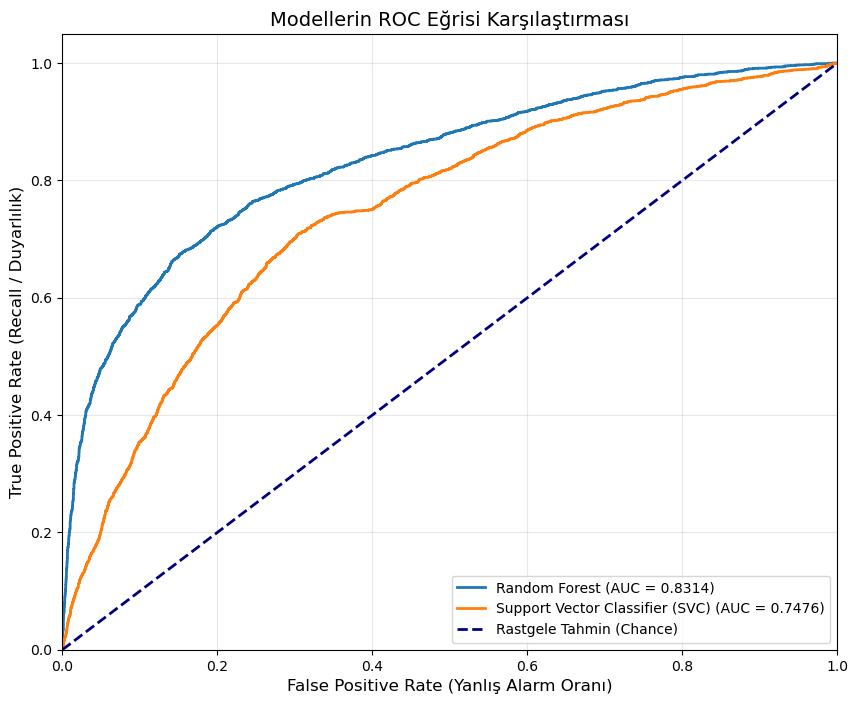

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_comparative_roc(models_dict, X_test, y_test):
    plt.figure(figsize=(10, 8))
    
    # Her model için döngü
    for name, model in models_dict.items():
        # 1. Tahmin Skorlarını Al (Olasılık veya Karar Fonksiyonu)
        if hasattr(model, "predict_proba"):
            # Random Forest vb. olasılık tabanlı modeller için
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            # SVC gibi karar fonksiyonu kullananlar için
            y_score = model.decision_function(X_test)
            
        # 2. FPR ve TPR Hesapla
        fpr, tpr, _ = roc_curve(y_test, y_score)
        
        # 3. AUC Skorunu Hesapla (Grafik etiketi için)
        roc_auc = auc(fpr, tpr)
        
        # 4. Çiz
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    
    # Rastgele Tahmin Çizgisi (Diagonal)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Tahmin (Chance)')
    
    # Grafik Ayarları
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)', fontsize=12)
    plt.ylabel('True Positive Rate (Recall / Duyarlılık)', fontsize=12)
    plt.title('Modellerin ROC Eğrisi Karşılaştırması', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# --- Çizimi Çalıştır ---

# 1. Karşılaştırılacak modelleri sözlüğe ekle
models_to_plot = {
    "Random Forest": rf_clf,
    "Support Vector Classifier (SVC)": svc_clf
}

# 2. Fonksiyonu çağır (PCA uygulanmış test verisi ile)
plot_comparative_roc(models_to_plot, X_test_pca, y_test_pca)